In [1]:
# Import libraries and data
import sys
import numpy as np

sys.path.append('../../')

from src.data_processing.column_import import s_x ,s_y ,v_x ,v_y ,a_x ,a_y 
from src.scripts.linear_regressor import perform_linear_regression

## Acceleration Model (4 params)


Here we solve the following system:
\begin{align}
    \begin{bmatrix}
        a_x(k-1) \\ 
        a_x(k-1) \\ 
        a_y(k-1) \\ 
        a_y(k-1)       
    \end{bmatrix}
    =
    \begin{bmatrix}
        -a_x(k)  & v_x(k-1) + v_x(k)  & 0 & 0                   \\ 
        0 & 0 & -a_x(k) &    s_x(k+1) - s_x(k) - dt \  v_x(k)   \\ 
        -a_y(k)  & v_y(k-1) - v_y(k)  & 0 & 0                   \\
        0 & 0 & -a_y(k) &    s_y(k+1) - s_y(k) - dt \  v_y(k)
    \end{bmatrix}
    \begin{bmatrix}
        \overline c_1 \\
        \overline c_2 \\
        \overline c_3 \\
        \overline c_4 \\
   \end{bmatrix}
\end{align}


We split the model into two models for easier implementation

\begin{align}
    \begin{bmatrix}
        a_x(k-1) \\ 
        a_y(k-1) \\ 
    \end{bmatrix}
    =
    \begin{bmatrix}
        -a_x(k)  & v_x(k-1) + v_x(k)   \\ 
        -a_y(k)  & v_y(k-1) + v_y(k)   \\
    \end{bmatrix}
    \begin{bmatrix}
        \overline c_1 \\
        \overline c_2 \\
   \end{bmatrix}
\end{align}



\begin{align}
    \begin{bmatrix}
        a_x(k-1) \\ 
        a_y(k-1)       
    \end{bmatrix}
    =
    \begin{bmatrix}
        -a_x(k) &    s_x(k+1) - s_x(k) - dt \  v_x(k)   \\ 
        -a_y(k) &    s_y(k+1) - s_y(k) - dt \  v_y(k)
    \end{bmatrix}
    \begin{bmatrix}
        \overline c_3 \\
        \overline c_4 \\
   \end{bmatrix}
\end{align}


Note: $dt = 0.04$



Our model is in the form of:
\begin{equation}
t = Ax
\end{equation}

We can solve this using least squares
\begin{equation}
||t-Ax||^2
\end{equation}



## Matrix creation

In [2]:
# Target vector y
y = np.concatenate([a_x[1:-1], a_y[1:-1]])    # a(k)
y.shape


(410362,)

In [3]:
# Input features X_a of the first model
A = - a_x[0:-2]                  # -a_y(k-1)  
B = - a_y[0:-2]                  # -a_y(k-1)  
C = v_x[2:] - v_x[1:-1]        # v_x(k+1) - v_x(k)
D = v_y[2:] - v_y[1:-1]        # v_y(k+1) - v_y(k)

X_a = np.vstack((
    np.column_stack((A, C)), 
    np.column_stack((B, D))
    ))
X_a.shape


(410362, 2)

In [4]:
# Input features X_b of the second model
dt = 0.04
A = - a_x[0:-2]                                  # - a_x(k-1)  
B = - a_y[0:-2]                                  # - a_y(k-1)  
C = s_x[2:] - s_x[1:-1] - dt * v_x[1:-1]        # s_x(k+1) - s_x(k) - dt v_x(k)
D = s_y[2:] - s_y[1:-1] - dt * v_y[1:-1]        # s_y(k+1) - s_y(k) - dt v_y(k)

X_b = np.vstack((
    np.column_stack((A, C)), 
    np.column_stack((B, D))
    ))
X_b.shape

(410362, 2)

## Perform Regression

Coefficients:
-0.9952707263309435
0.0004123927826127597
Mean Squared Error: 0.003702764453022485
R-squared (R2) Score: 0.9886269955859615


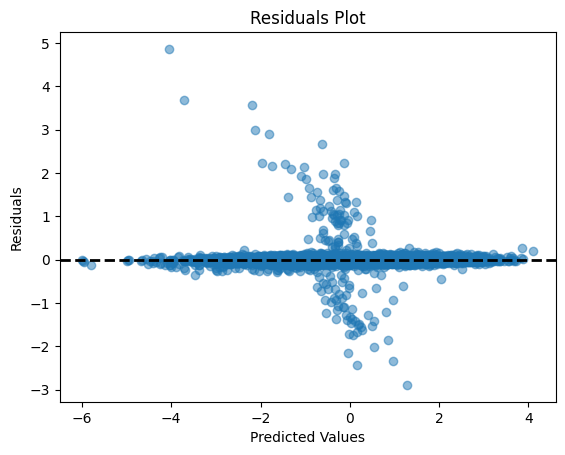

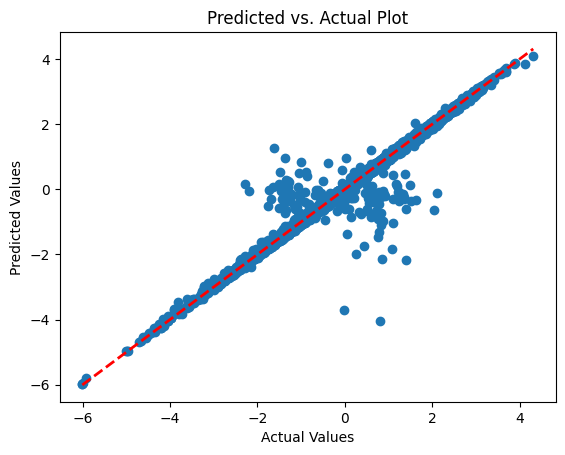

In [5]:
# First model
perform_linear_regression(X_a, y)


Coefficients:
-0.9952856938198771
-6.916934667762276e-07
Mean Squared Error: 0.003702850091776299
R-squared (R2) Score: 0.9886267325473758


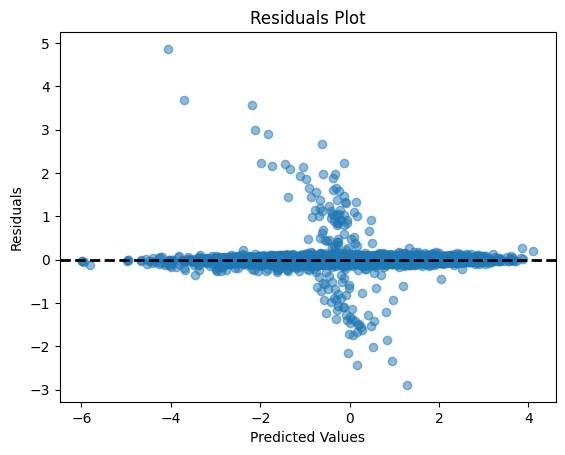

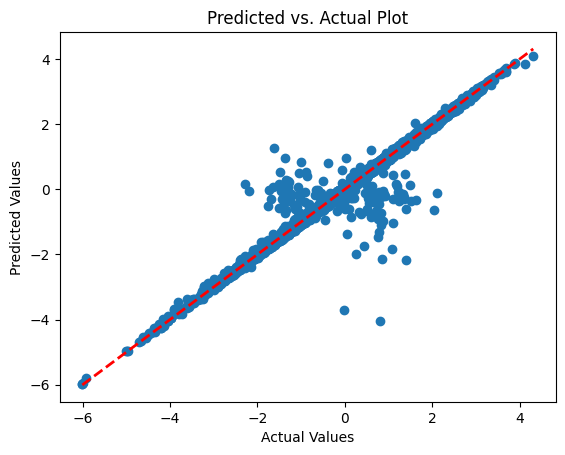

In [6]:
# Second model
perform_linear_regression(X_b, y)